In [1]:
# Runs the SARSA algorithm on the training set to find the action value function (Q function) under
# the physician policy. 
# TODO update this for shaped reward functions (once new_rewards.ipynb is updated)

In [2]:
import pandas as pd
import numpy as np
from pandas import DataFrame

In [3]:
# df = pd.read_csv("rl_train_set.csv")
df = pd.read_csv("../data/rl_train_data_final_discrete.csv")
df.head()

,Unnamed: 0,bloc,icustayid,state,reward,max_dose_vaso,iv_tev_in,mortality
0,0,1,3,1128,0,0.0,4.0,0
1,1,2,3,1128,0,0.0,4.0,0
2,2,3,3,1172,0,0.0,2.0,0
3,3,4,3,1172,0,0.0,2.0,0
4,4,5,3,464,0,0.0,2.0,0


In [4]:
#hyperparams
alpha = 0.1
# gamma = 0.99
gamma = 1

In [5]:
# define an action mapping - how to get an id representing the action from the (iv,vaso) tuple
# this is copied over from find_transition_matrix. Should really pass as argument - todo for when this
# is implemented properly!
action_map = {}
count = 0
for iv in range(5):
    for vaso in range(5):
        action_map[(iv,vaso)] = count
        count += 1

In [7]:
# get the unique ids
unique_ids = df['icustayid'].unique()

In [13]:
q_new = np.zeros((1250,25), dtype=np.float32)

In [14]:
REWARD_THRESHOLD = 15

In [15]:
import sys
def q_learn_backwards_new(trajectory):
    global q_new
    #count indexes the rows in the dataframe from zero - row doesn't
    count = 0
    reversed_traj = trajectory.iloc[::-1]
    for row in reversed_traj.index:
        count += 1          
        iv = int(reversed_traj.ix[row, 'iv_tev_in'])
        vaso = int(reversed_traj.ix[row, 'max_dose_vaso'])
        action = action_map[iv,vaso]
        state = reversed_traj.ix[row,'state']
        reward = reversed_traj.ix[row,'reward']
        if reward > REWARD_THRESHOLD:
            reward = REWARD_THRESHOLD
        elif reward < -1* REWARD_THRESHOLD:
            reward = -1 * REWARD_THRESHOLD
        assert(abs(reward) <= REWARD_THRESHOLD)
        if count == 1:
            if reward == 0:
                print "length is ", len(trajectory)
                print "count is ", count
                print reversed_traj
                sys.exit(-1)
            else:
                q_new[state, action] = q_new[state, action] + alpha * (reward - q_new[state,action])
        else:
            try:
                next_state = reversed_traj.ix[row + 1,'state']
            except KeyError:
                print "row is ", row
                print reversed_traj
                raise
            # COMMENT OUT NEXT FOUR if we wish to learn Qstar - the optimal q function
            next_iv = int(reversed_traj.ix[row+1, 'iv_tev_in'])
            next_vaso = int(reversed_traj.ix[row+1, 'max_dose_vaso'])
            next_action = action_map[next_iv,next_vaso]
            next_action_value = q_new[next_state,next_action]
#             next_action_value = np.max(q_new[next_state])

            q_new[state, action] = q_new[state, action] + \
                            alpha * (reward + gamma * next_action_value - q_new[state,action])

In [16]:
# new main loop
# the main loop - sample from unique_ids and extract the trajectory
# perform the q value update on these data
net_qs = []
num_steps = 250000
for step in range(num_steps):
    if step % 1000 == 0:
        net_qs.append(np.sum(q_new))
    if step % 10000 == 0:
        print step
    traj_id = np.random.choice(unique_ids)
    # select the rows that match this traj id
    trajectory = df.loc[df['icustayid'] == traj_id]
    if len(trajectory) > 1:
        q_learn_backwards_new(trajectory)

0
10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000
180000
190000
200000
210000
220000
230000
240000


<function matplotlib.pyplot.show>

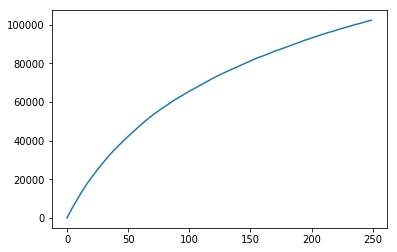

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(net_qs)
plt.show

In [20]:
# pickle the q vals to file for purposes of evaluation
# included the discount factor in the filename for ease later
import cPickle as pickle
with open('q_table_phys_policy_gamma_1.p', 'wb') as f:
    pickle.dump(q_new, f)

In [ ]:
policy = np.zeros(1250, dtype=np.int)
for state in range(1250):
    best_action = np.argmax(q_new[state])
    if best_action is None:
        policy[state] = 0
    else:
        policy[state] = best_action

In [ ]:
with open('policy_discrete_sarsa.p', 'wb') as f:
    pickle.dump(policy, f)